# Image Quality Evaluations of XCIST

The purpose of this is to validate the image quality of the XCIST simulator based on the IEC61223-3-5 for acceptance testing, these testes include:

| PROTOCOL ELEMENT | MEAN CT NUMBER                       | NOISE                                               | UNIFORMITY             |
|------------------|--------------------------------------|-----------------------------------------------------|------------------------|
| Adult Head       | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |
| Adult Body       | Nominal value ± 6 HU (Large PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Large PHANTOM) | ≤ 8 HU (Large PHANTOM) |
| Paediatric Head  | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |
| Paediatric Body  | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |

Spatial Resolution, Artifacts, CTDI

In [1]:
import pydicom
import numpy as np

def read_dicom(dcm):
    assert(isinstance(dcm, pydicom.dataset.FileDataset))
    return dcm.pixel_array + dcm.RescaleIntercept
dcm = pydicom.read_file('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms/CTP404/diameter_350mm/350mm_CTP404_groundtruth.dcm')
phantom = read_dicom(dcm)
phantom = np.repeat(phantom[None], 200, axis=0)
phantom.shape

(200, 512, 512)

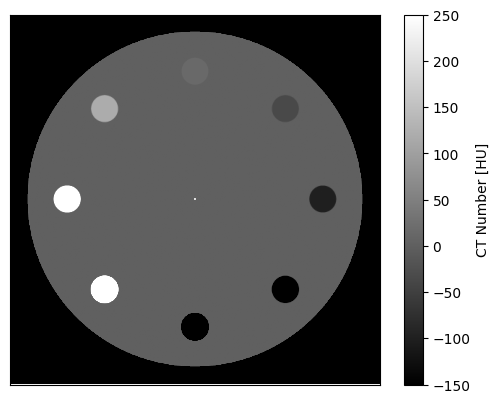

In [2]:
import matplotlib.pyplot as plt
from utils import ctshow, scrollview
im = ctshow(phantom)
plt.colorbar(im, label='CT Number [HU]')

In [3]:
from pedsilicoICH.image_acquisition import CTobj

In [4]:
from dxcist.xcist_sims import get_effective_diameter

In [5]:
diameter_pixels = get_effective_diameter(phantom[0], 1)
known_diameter_mm = 200
fov_mm = phantom.shape[-1]*known_diameter_mm/diameter_pixels
fov_mm
dx = fov_mm/phantom.shape[-1]
dx

np.float64(0.4301413648682815)

In [6]:
ct = CTobj(phantom, spacings=3*[dx], patientname='CTP404')

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.4301413648682815-mm pixels (XY), 0.4301413648682815-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 200 slices...
* Writing volume fra

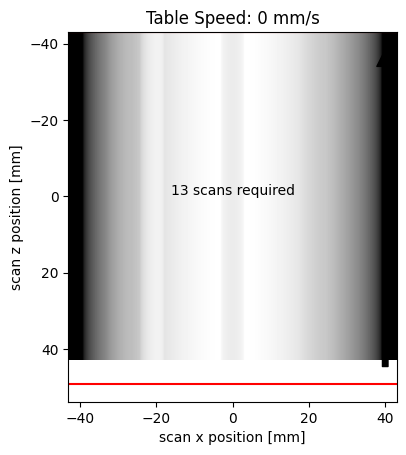

In [7]:
ct.scout_view()

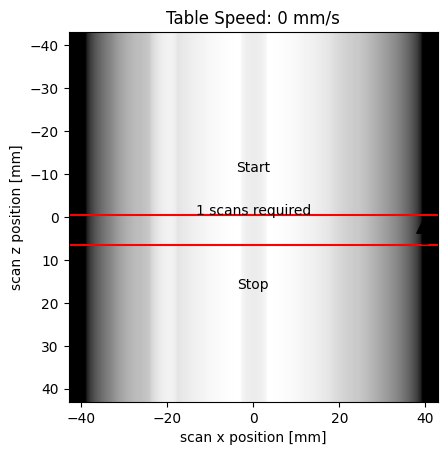

In [8]:
ct.scout_view(startZ=-5, endZ=1)

In [9]:
ct.run_scan(startZ=-5, endZ=1, views=1000)

scan: 1/1
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                    | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1000 MB.


100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [30:28<00:00,  1.83s/it]


Prep view
Applying LSC...done.

Simulation is done.


<class 'pedsilicoICH.image_acquisition.CTobj'> default

In [10]:
ct.run_recon(fov=fov_mm)

fov size: 220.2323788125601
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


<class 'pedsilicoICH.image_acquisition.CTobj'> default
Recon: (7, 512, 512) 22.023237881256012 cm fov
Projections: (1000, 16, 900)

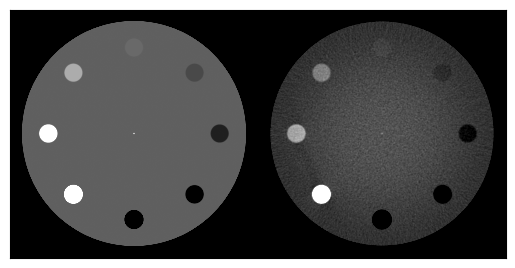

In [11]:
ctshow(np.concatenate([ct.phantom[0], ct.recon[0]], axis=1))

In [12]:
ct.xcist.protocol.mA

200

## Noise vs mA level

looking for 1/sqrt(mA) behaviour, or variance = linear

In [13]:
from pathlib import Path
import os

In [14]:
mA_dir = Path('mA_test')
if mA_dir.exists():
    mA_dict = {}
    for mA in os.listdir(mA_dir):
        mA_dict[int(mA)] = np.stack([read_dicom(pydicom.read_file(o)) for o in (mA_dir / mA).glob('*.dcm')])
else:
    views = 1000
    mAs = np.linspace(10, 500, 10, dtype=int)
    recons = []
    for mA in mAs:
        ct.run_scan(startZ=-5, endZ=1, views=views, mA=mA)
        ct.run_recon(sliceThickness=1)
        ct.write_to_dicom(f'/{mA:03d}/{mA:03d}.dcm')
        recons.append(ct.recon)
    mA_recons = np.stack(recons)
    mA_dict = dict(zip(mAs, mA_recons))

In [15]:
mA_dict.keys()

dict_keys([10, 64, 118, 173, 227, 282, 336, 391, 445, 500])

In [16]:
scrollview(mA_dict[10])

interactive(children=(IntSlider(value=3, description='idx', max=6), Output()), _dom_classes=('widget-interact'…

## Noise vs kVp level

In [17]:
kV_dir = Path('kVp_test')
if kV_dir.exists():
    kVp_dict = {}
    for kV in os.listdir(kV_dir):
        kVp_dict[int(kV)] = np.stack([read_dicom(pydicom.read_file(o)) for o in (kV_dir / kV).glob('*.dcm')])
else:
    kVps = np.arange(70, 140, 10, dtype=int)
    recons = []
    for kVp in kVps:
        ct.run_scan(startZ=-5, endZ=1, views=views, mA=500, kVp=kVp)
        ct.run_recon(sliceThickness=1)
        ct.write_to_dicom(f'{kV_dir} / {kVp:03d} / {kVp:03d}.dcm')
        recons.append(ct.recon)
    kVp_recons = np.stack(recons)
    kVp_dict = dict(zip(kVps, kVp_recons))

In [18]:
mA_dict.keys(), kVp_dict.keys()

(dict_keys([10, 64, 118, 173, 227, 282, 336, 391, 445, 500]),
 dict_keys([70, 80, 90, 100, 110, 120, 130]))

In [19]:
scrollview(kVp_dict[70])

interactive(children=(IntSlider(value=3, description='idx', max=6), Output()), _dom_classes=('widget-interact'…

Text(0.5, 1.0, '[10, 227, 445] mA')

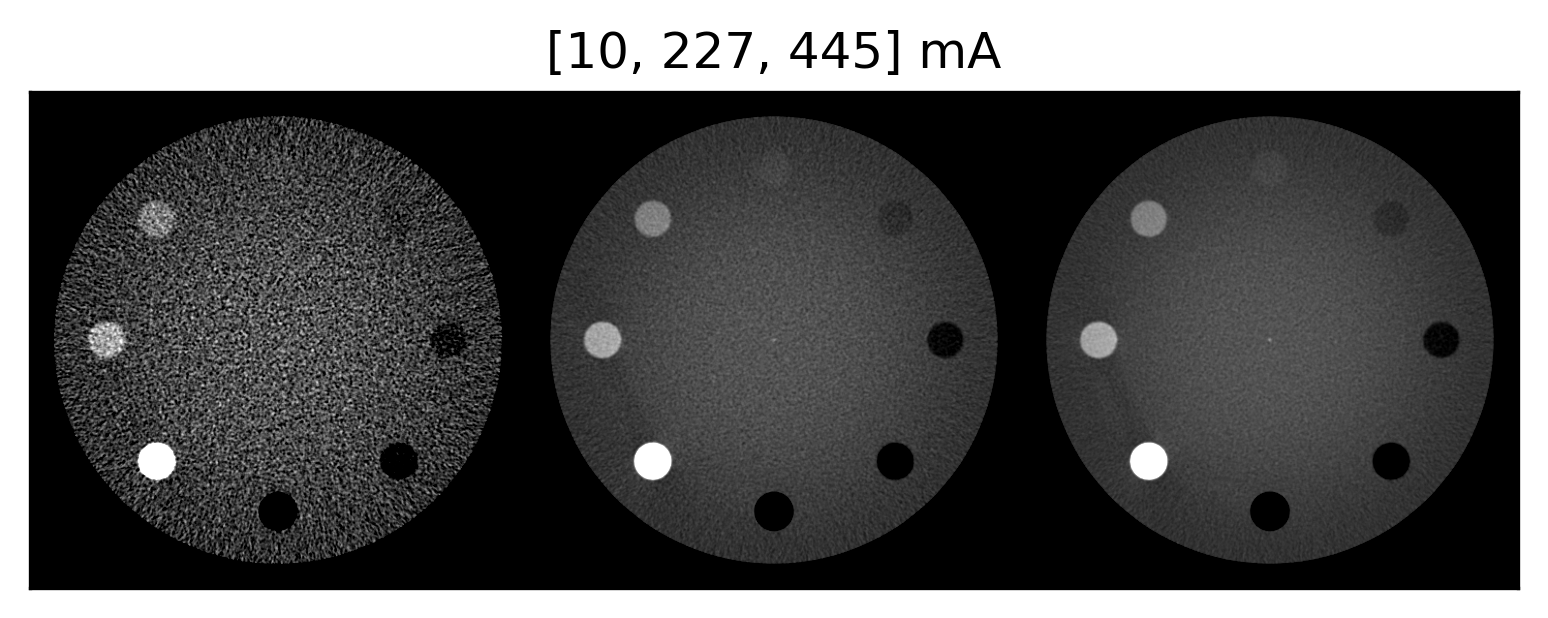

In [20]:
f, ax = plt.subplots(dpi=300)
sample_mAs = list(mA_dict.keys())[::4]
ctshow(np.concatenate([mA_dict[k][0] for k in sample_mAs], axis=1), fig=f, ax=ax)
ax.set_title(f'{sample_mAs} mA')

Text(0.5, 1.0, '[70, 100, 130] kVp')

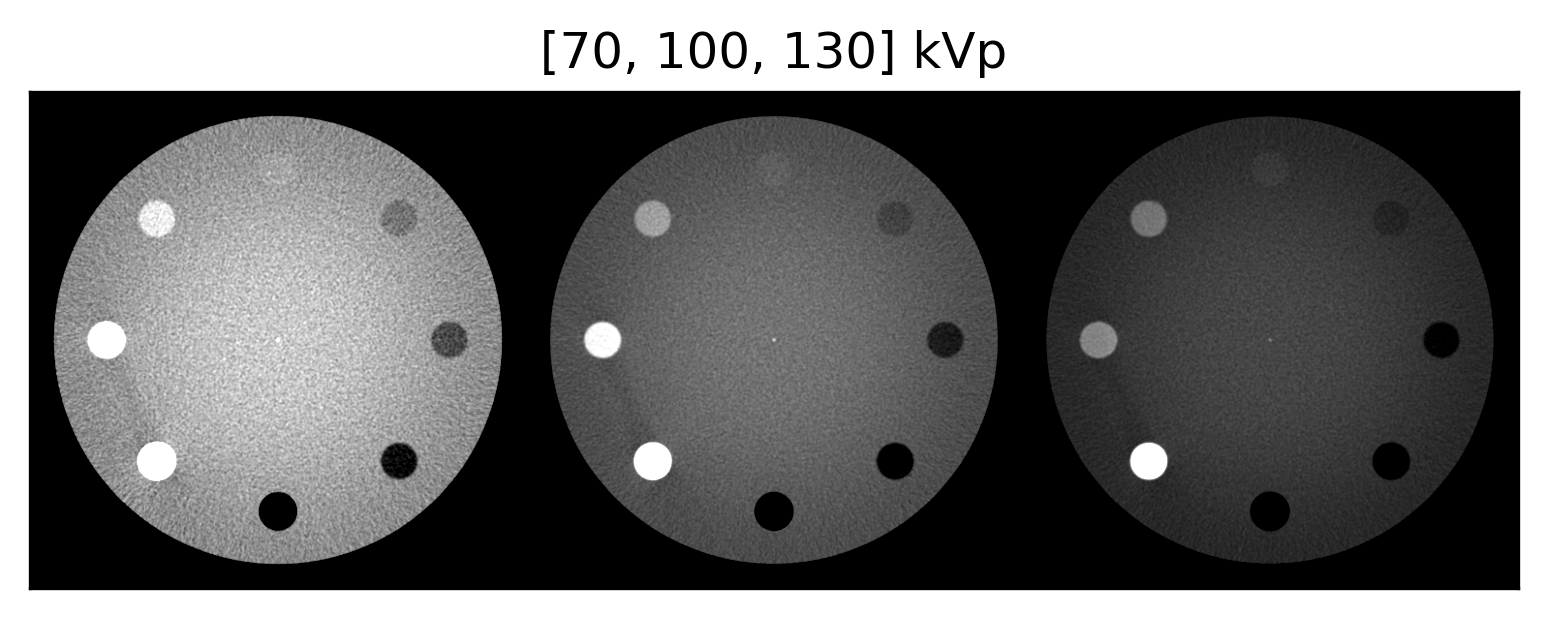

In [21]:
f, ax = plt.subplots(dpi=300)
sample_kVs = list(kVp_dict.keys())[::3]
ctshow(np.concatenate([kVp_dict[k][0] for k in sample_kVs], axis=1), fig=f, ax=ax)
ax.set_title(f'{sample_kVs} kVp')